In [19]:
import pandas as pd
import numpy as np

In [20]:
# values in pixels
monitor_w = 1920
monitor_h = 1080

# coords from Eyelink starts from (0,0), will be useful in the future
monitor_w -=1
monitor_h -=1

In [21]:
# Open the .asc file
# This script was written and tested on data from Eyelink recorded for one eye
data = []
path_file = 'PB2006.asc'    # change it to path to .asc file; format - string
with open(path_file, 'r', encoding='latin1') as file:
    for line in file:
        values = line.split()
        data.append(values)

In [22]:
data = data[194:] # cutting rows that are unnecessary (optional); value may differ

In [23]:
# find start and end datapoints
for i, row in enumerate(data):
    if "TRIAL_BEZPRAWIE_ONSET" in row:  # search all rows in data untill specific value occurs
        start_index = i
        break

for j, row in enumerate(data[start_index+1:]):
    if "DOTS_OFFSET" in row:    # search all rows starting from start_index untill nearest value
        end_index = start_index + j + 1
        break

# slice data
print(f'Slicing begins from: {data[start_index]}\nSlice ends at: {data[end_index]}')
data_slice = data[start_index:end_index]

Slicing begins from: ['MSG', '7418481', 'TRIAL_BEZPRAWIE_ONSET']
Slice ends at: ['MSG', '7421313', 'DOTS_OFFSET']


In [24]:
# find and save all events in slice
interest_list = ['MSG']

interest_rows = []
interest_index = []
for index, row in enumerate(data_slice):
    for event in interest_list:
        if event in row:
            interest_rows.append(row)
            interest_index.append(index)


interest_rows

[['MSG', '7418481', 'TRIAL_BEZPRAWIE_ONSET'],
 ['MSG', '7419049', 'SENTECE_OFFSET'],
 ['MSG', '7419049', 'FIXBRK_ONSET'],
 ['MSG', '7419308', 'DOTS_ONSET']]

In [25]:
# delete all events from data - leave only timepoints and coords
msg_list = ['MSG', 'EFIX', 'SSACC', 'SFIX', 'ESACC', 'EBLINK', 'SBLINK']
indexes_to_delete = []

for event in msg_list:
    for index, row in enumerate(data_slice):
        if event in row:
            indexes_to_delete.append(index)
    
    for index in sorted(indexes_to_delete, reverse=True):
        data_slice.pop(index)
    indexes_to_delete = []

In [26]:
# change data into format: [[tp1, x1, y1], [tp2, x2, y2], ..., [tpn, xn, yn]]
time_coords_list = [inner_list[:3] for inner_list in data_slice]

# change timepoints into format relative to the beginning of the slice (starts from 0)
time_coords_list = [[str(float(i)), inner_list[1], inner_list[2]] for i, inner_list in enumerate(data_slice)]

# change lacks of data (coords '.') into -1
time_coords_list = [[-1 if item == '.' else item for item in inner_list] for inner_list in time_coords_list]

# get the time axis 
time = [float(inner_list[0]) for inner_list in time_coords_list]

# get the data for eye movement in separate axes
# Eyelink starts iterating pixels from upper left, so y_axis conversion is needed
x_axis = [float(inner_list[1]) for inner_list in time_coords_list]
y_axis = [monitor_h - float(inner_list[2]) for inner_list in time_coords_list]

# if values are above range of monitors set it to minimum or maximum number
#x_axis = [0 if x < 0 else x for x in x_axis]
#x_axis = [0 if x > monitor_w else x for x in x_axis]

#y_axis = [0 if y < 0 else y for y in y_axis]
#y_axis = [0 if y > monitor_h else y for y in y_axis]

# alternative - set value to "-axis", to not display it on plot

x_axis = [-monitor_w if x < 0 else x for x in x_axis]
x_axis = [-monitor_w if x > monitor_w else x for x in x_axis]

y_axis = [-monitor_h if y < 0 else y for y in y_axis]
y_axis = [-monitor_h if y > monitor_h else y for y in y_axis]

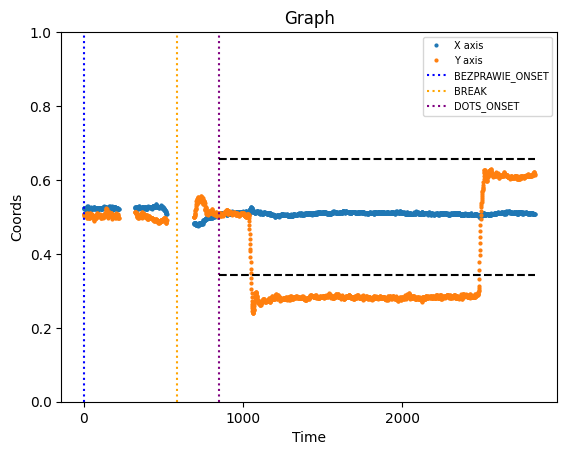

In [27]:
import matplotlib.pyplot as plt

# scale it to range 0 - 1
filtered_X = [x/monitor_w for x in x_axis]
filtered_Y = [y/monitor_h for y in y_axis]

plt.xticks(np.arange(0, max(time) + 1, 1000))   # show time points every 1000 ms

plt.plot(time, filtered_X, 'o', markersize= 2, linestyle='None', label='X axis')
plt.plot(time, filtered_Y, 'o', markersize= 2, linestyle='None', label='Y axis ')

# show vertical lines at points of interest
plt.vlines(x=interest_index[0], ymin=0, ymax=1, linestyle='dotted', color='blue', label='BEZPRAWIE_ONSET')
plt.vlines(x=interest_index[2], ymin=0, ymax=1, linestyle='dotted', color='orange', label='BREAK')
plt.vlines(x=interest_index[3], ymin=0, ymax=1, linestyle='dotted', color='purple', label='DOTS_ONSET')


# show horizontal lines at coordinates of target (values needs to be set from your procedure)
plt.hlines(y=0.5-170/1080, xmin=interest_index[3], xmax=time[-1], linestyle='dashed', color='black')
plt.hlines(y=0.5+170/1080, xmin=interest_index[3], xmax=time[-1], linestyle='dashed', color='black')

plt.ylim(0,1)   # show range from 0 to 1 to exclude values that are below or above monitor range

plt.xlabel('Time')
plt.ylabel('Coords')
plt.title('Graph')
plt.legend(fontsize="7")

# save plot to file
# plt.savefig('plot.png', dpi=300)

plt.show()